# Tarea 4

## Estudiante: Andrés Calderón Guardia

Usamos un dataset de analisis de sentimiento multimodal **centrada en entidades** en tweets. Cada tweet viene con una etiqueta entre `positive`, `negative` y `neutral`.

Los tweets vienen de este formato textual, y cada tweet tiene una imagen:

* `Harriette </s> $T$ moved back to Chicago to care for her mom : And it ' s been terrible # NextDayChi 17` tiene la etiqueta `neutral` y la imagen `twitter2015_images/71274.jpg`
* `Chicago </s> Harriette moved back to $T$ to care for her mom : And it ' s been terrible # NextDayChi 17` tiene la etiqueta `negative` y la imagen `twitter2015_images/71274.jpg`

**Vamos a ver como usar:**
* Fusionar datos de imagenes y de texto para una tarea de clasificacion
* Utilizar las representaciones de las imagenes modalidades tal que (pesos de los encoders congelados)
* Fine-tunear todo el network
* Tratar varios metodos de fusion con capa de attencion
* Utilizar un modelo grande pre-entrenado de manera multimodal como VL-BERT or ViLT
* Utilizar un LMM tipo BLIP3 pre-entrenado con instrucciones, usando Zero-shot

## Se puede utilizar LLM para ayudarse!
Mirar a [un ejemplo](https://chatgpt.com/share/d534833e-bd2c-40c1-81eb-34818b195cac) de como pedir las respuestas a un LLM. Mejor si entenden lo que hagan.

#### Para cada entrenamiento
* Informa de las curvas de pérdida y precisión en el entrenamiento y la validación.
* Detén el entrenamiento en función de los resultados obtenidos en el conjunto de validación.
* Utiliza una tasa de aprendizaje pequeña para que puedas ver cómo disminuye la pérdida en las distintas curvas.  

### Before Starting! Some tips on GPU and Google Colab

You will likely to run this code on Google Colab in order to use GPU ressources. If not, the code will take 60 times more to run!!  

#### Stop disconnection

Colab will disconnect you if you the training is too long. In order to prevent this, you can use this piece of code in the console of your browser:

```java
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

See more [here](https://www.reddit.com/r/StableDiffusion/comments/xhhlp0/automatic1111_on_colab_how_to_keep_it_running/).

#### Other account

If you run out of available ressources, what you can do is changing of the account you are using in colab. You can create another gmail and switch to it, this should give you more GPU ressources.

Good luck!

In [ ]:
! wget https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Texts_Targeted.zip
! unzip Texts_Targeted.zip

In [ ]:
! wget https://users.dcc.uchile.cl/~vbarrier/MModal_Sentiment/Images.zip
! unzip Images.zip

In [ ]:
import pandas as pd

def read_data(fn):
    df = pd.read_csv(fn, sep='\t')[['tweet', 'label', 'image_id']]
    X = df.tweet
    y = df.label
    path_image = df.image_id
    return X, y, path_image

split='train'
X_train, y_train, path_image_train = read_data('MModal_Targeted_Sentiment_%s.tsv'%split)
split='dev'
X_dev, y_dev, path_image_dev = read_data('MModal_Targeted_Sentiment_%s.tsv'%split)
split='test'
X_test, y_test, path_image_test = read_data('MModal_Targeted_Sentiment_%s.tsv'%split)

## Modelizacion

**Metricas**: Para este tarea de clasificacion pueden utilizar el score F-1 para estimar las performancias de los modelos  

**Multimodal Fusion**: The principle is to encode each modality and fuse them together.   

**Text Encoding**: You need to encode the text into a vector. Implement:
* a simple text encoding using a Bag-of-Word and a tf-idf, or an encoding using word2vec and aggregation using the arithmetic mean,
* an encoding using RoBERTa by taking the `<s>` token

In [ ]:
import numpy as np
import torch, os, matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from transformers import RobertaTokenizer, RobertaModel

In [ ]:
# tf-idf encoding
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_dev_enc = le.transform(y_dev)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# RoBERTa encoding
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the tweets
X_train_tokenized = tokenizer(
    X_train.tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)
X_dev_tokenized = tokenizer(
    X_dev.tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)
X_test_tokenized = tokenizer(
    X_test.tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

**Image Encoding**: You need to encode the image into a vector using an already pre-trained CNN that will create a representation of the image:
* an EfficientNetB2 or EfficientNetB3 pre-trained over ImageNet
* an EfficientNetB2 or EfficientNetB3 already fine-tuned over the Emotion Recognition dataset

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
# Pre-trained
pre_trained = EfficientNet.from_pretrained('efficientnet-b3')

# This model was fine-tuned using the second homework
fine_tuned = torch.load("/content/efficient_net_B3_fine_tuned.pt")

Loaded pretrained weights for efficientnet-b3


<ipython-input-52-8ecde34f5206>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fine_tuned = torch.load("/content/efficient_net_B3_fine_tuned.pt")


#### Text Transformer Model

Use a pre-trained model from the HuggingFace library and fine-tune it on the dataset.

* For the data, you can use the classes `DataLoader` and `DataLoader` from `torch.utils.data`
* For the modelization:
  * You can use the classes `AutoTokenizer` and `AutoModel` from the `transformers` library
  * Load the weights of the models already pre-trained, with the associated tokenizer!
  * You can use a [classical roberta](https://huggingface.co/roberta-base) `'roberta-base'`
  * You can also use another model from huggingface, like [a smaller model](https://huggingface.co/distilbert-base-uncased) such as `distilbert-base-uncased` (it is an example). Be careful if you do this! You will need to change the separation token of the tweets (which is `</s>` here)
  
#### Multimodal Model

* For the fine-tuning (optimization):
    * Make the loop in pytorch, **do not use** the class `Trainer` from the `transformers` library
    * You can use classical loss functions like cross-entropy and the optimizer you want, `Adam` or `AdamW` for example, you can set the learning rate to `1e-5`, a batch size of `32` and `10` epochs. Be sure that you are converging well, by looking at the train and validation loss curves. These values worked for me!

```python
optimizer_params = {
    'lr': 1e-5,
    'batch_size': 32,
    'num_epochs':10,
}
```

### Naive Fusions

* Concatenate the audio and text representations: before naively fusing them with a MLP layer
* Concatenate the penultimate layers (neural representations): the `<s>` vector for RoBERTa and the representation of the EfficientNet
* Finally, when using the text encoder and the image encoder, run another experiment unfreezing the parameters of the whole network during fine-tuning
* You can try using an EfficientNet already fine-tuned over the Emotion dataset and see the differences, it should help!  

## Utils:

Code functions that can be utils for this task:
* `MultimodalDataset(torch.utils.data.Dataset)` class that is modular with the different type of encodings from `torch.utils.data.Dataset`
* `training()` function with the training loop
* A class `MultimodalClassifier(nn.Module)` containing the network _per se_.

Use data augmentation for the vision modality:
```python
rotation_value = 0.2
# Image transformations for EfficientNet
# For validation/test
self.image_transform = transforms.Compose([
        transforms.CenterCrop(self.image_size),
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Apply data augmentation at training
self.image_transform_data_augmentation = transforms.Compose([
    # transforms.RandomRotation(angle_rotation) # check if this works
    transforms.RandomResizedCrop(self.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=rotation_value * 360),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
```

Also do not forget other regularizers like `Torch.nn.dropout` in the multimodal layers!

In [ ]:
from torch.nn import MultiheadAttention
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from torch import optim
from torchvision import models, transforms

In [ ]:
def print_plots(train_losses, dev_losses, metric="Loss"):
    # Plotting training and validation of the given metric
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f"Training {metric}")
    plt.plot(dev_losses, label=f"Validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric}")
    plt.title(f"Training and Validation {metric} Curve")
    plt.legend()
    plt.show()

### 4 experiments using naive fusion

#### Without RoBERTa + frozen-EfficientNet

In [ ]:
# Dataset class
class MultimodalDataset(Dataset):
    def __init__(self, X_text_tfidf, image_paths, y_labels, augment=False):
        self.X_text_tfidf = X_text_tfidf
        self.image_paths = image_paths
        self.y_labels = y_labels
        self.augment = augment
        self.image_size = 224

        rotation_value = 0.2
        # Image transformations
        self.image_transform = transforms.Compose([
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.image_transform_data_augmentation = transforms.Compose([
            transforms.RandomResizedCrop(self.image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=rotation_value * 360),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.y_labels)

    def __getitem__(self, idx):
        # Get text vector
        text_vector = self.X_text_tfidf[idx].toarray().squeeze()
        text_vector = torch.tensor(text_vector, dtype=torch.float32)

        # Get image
        image_path = self.image_paths.iloc[idx]
        image_file = os.path.join(str(image_path))
        image = Image.open(image_file).convert('RGB')
        if self.augment:
            image = self.image_transform_data_augmentation(image)
        else:
            image = self.image_transform(image)

        label = self.y_labels[idx]
        return text_vector, image, label

In [ ]:
# Create datasets and dataloaders
batch_size = 32

train_dataset = MultimodalDataset(X_train_tfidf, path_image_train, y_train_enc, augment=True)
dev_dataset = MultimodalDataset(X_dev_tfidf, path_image_dev, y_dev_enc)
test_dataset = MultimodalDataset(X_test_tfidf, path_image_test, y_test_enc)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self, text_feature_size, num_classes):
        super(MultimodalClassifier, self).__init__()
        # Image encoder
        self.image_model = pre_trained
        # Freeze image model parameters
        for param in self.image_model.parameters():
            param.requires_grad = False
        # Get the number of features from image model
        image_feature_size = self.image_model._fc.in_features  # 1408 for EfficientNet-B2

        # Fusion and classifier
        self.classifier = nn.Sequential(
            nn.Linear(text_feature_size + image_feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, text_vector, image):
        # Image features
        image_features = self.image_model.extract_features(image)
        image_features = nn.functional.adaptive_avg_pool2d(image_features, (1, 1))
        image_features = image_features.view(image_features.size(0), -1)

        # Fuse features
        fused_features = torch.cat((text_vector, image_features), dim=1)

        # Classify
        output = self.classifier(fused_features)
        return output

# Initialize model
text_feature_size = X_train_tfidf.shape[1]  # 5000
model = MultimodalClassifier(text_feature_size, num_classes)

In [ ]:
# Training function
def training(model, train_loader, dev_loader, criterion, optimizer, num_epochs, device):
    model.to(device)

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    best_val_f1 = 0.0
    patience = 3
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for text_vector, images, labels in train_loader:
            text_vector = text_vector.to(device)
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(text_vector, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * text_vector.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for text_vector, images, labels in dev_loader:
                text_vector = text_vector.to(device)
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(text_vector, images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * text_vector.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(dev_loader.dataset)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}')

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pt'))

    return model, train_losses, val_losses, train_f1_scores, val_f1_scores

Epoch 1/10, Train Loss: 1.0466, Train F1: 0.3898, Val Loss: 1.0518, Val F1: 0.3586
Epoch 2/10, Train Loss: 0.9947, Train F1: 0.3696, Val Loss: 1.0315, Val F1: 0.3609
Epoch 3/10, Train Loss: 0.9843, Train F1: 0.3694, Val Loss: 1.0224, Val F1: 0.3698
Epoch 4/10, Train Loss: 0.9793, Train F1: 0.3711, Val Loss: 1.0166, Val F1: 0.3712
Epoch 5/10, Train Loss: 0.9724, Train F1: 0.3761, Val Loss: 1.0116, Val F1: 0.3806
Epoch 6/10, Train Loss: 0.9677, Train F1: 0.3915, Val Loss: 1.0083, Val F1: 0.3900
Epoch 7/10, Train Loss: 0.9662, Train F1: 0.3991, Val Loss: 1.0049, Val F1: 0.3913
Epoch 8/10, Train Loss: 0.9601, Train F1: 0.3959, Val Loss: 1.0026, Val F1: 0.4040
Epoch 9/10, Train Loss: 0.9593, Train F1: 0.4154, Val Loss: 0.9998, Val F1: 0.4089
Epoch 10/10, Train Loss: 0.9575, Train F1: 0.4160, Val Loss: 0.9972, Val F1: 0.4068


<ipython-input-58-e1a58ed378fa>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


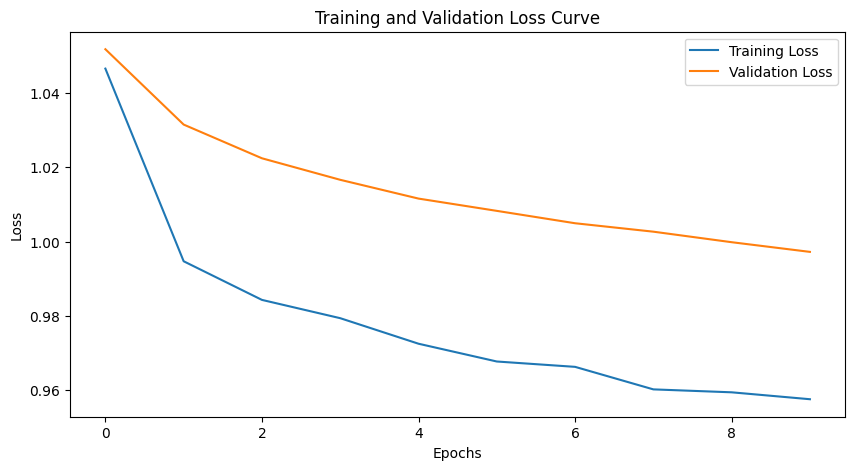

Test F1-score: 0.4201


In [ ]:
# Set up training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-5)
num_epochs = 10

# Train the model
model, train_losses, val_losses, train_f1_scores, val_f1_scores = training(model, train_loader, dev_loader,
                                                                           criterion, optimizer, num_epochs, device)

print_plots(train_losses, val_losses)

# Evaluate on test set
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for text_vector, images, labels in test_loader:
        text_vector = text_vector.to(device)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(text_vector, images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'Test F1-score: {test_f1:.4f}')

#### frozen-RoBERTa + frozen-EfficientNet

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, text_inputs, image_paths, y_labels, augment=False):
        self.text_inputs = text_inputs  # Tokenized RoBERTa inputs
        self.image_paths = image_paths
        self.y_labels = y_labels
        self.augment = augment
        self.image_size = 224

        rotation_value = 0.2
        # Image transformations
        self.image_transform = transforms.Compose([
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.image_transform_data_augmentation = transforms.Compose([
            transforms.RandomResizedCrop(self.image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=rotation_value * 360),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.y_labels)

    def __getitem__(self, idx):
        # Text inputs (tokenized by RoBERTa)
        text_input = {key: val[idx] for key, val in self.text_inputs.items()}

        # Get image
        image_path = self.image_paths.iloc[idx]
        image_file = os.path.join(str(image_path))
        image = Image.open(image_file).convert('RGB')
        if self.augment:
            image = self.image_transform_data_augmentation(image)
        else:
            image = self.image_transform(image)

        # Label
        label = self.y_labels[idx]
        return text_input, image, label

In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self, roberta_model_name='roberta-base', num_classes=10):
        super(MultimodalClassifier, self).__init__()

        # Load frozen RoBERTa
        self.text_encoder = AutoModel.from_pretrained(roberta_model_name)
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Load frozen EfficientNetB3
        self.image_encoder = pre_trained
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        # Fusion and classifier
        text_feature_size = self.text_encoder.config.hidden_size  # 768 for roberta-base
        image_feature_size = 1536  # EfficientNetB3 output size
        fused_size = text_feature_size + image_feature_size

        self.classifier = nn.Sequential(
            nn.Linear(fused_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, text_inputs, images):
        # Text features
        text_outputs = self.text_encoder(**text_inputs)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Use <s> token

        # Image features
        image_features = self.image_encoder(images)
        image_features = image_features.view(image_features.size(0), -1)

        # Fuse features
        fused_features = torch.cat((text_features, image_features), dim=1)

        # Classify
        outputs = self.classifier(fused_features)
        return outputs

In [ ]:
def training(model, train_loader, dev_loader, criterion, optimizer, num_epochs, device):
    model.to(device)

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    best_val_f1 = 0.0
    patience = 3
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for text_inputs, images, labels in train_loader:
            # Move inputs to device
            text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(text_inputs, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for text_inputs, images, labels in dev_loader:
                text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(text_inputs, images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(dev_loader.dataset)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}')

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

    model.load_state_dict(torch.load('best_model.pt'))
    return model, train_losses, val_losses, train_f1_scores, val_f1_scores

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for text_inputs, images, labels in data_loader:
            # Move inputs to device
            text_inputs = {key: val.to(device) for key, val in text_inputs.items()}
            images = images.to(device)
            labels = labels.to(device)

            # Make predictions
            outputs = model(text_inputs, images)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds, average='weighted')
    report = classification_report(test_labels, test_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1-score: {f1:.4f}")
    print("Classification Report:")
    print(report)

    return accuracy, f1, report

In [ ]:
# Initialize dataset and dataloaders
train_dataset = MultimodalDataset(X_train_tokenized, path_image_train, y_train_enc, augment=True)
dev_dataset = MultimodalDataset(X_dev_tokenized, path_image_dev, y_dev_enc)
test_dataset = MultimodalDataset(X_test_tokenized, path_image_test, y_test_enc)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model
num_classes = len(set(y_train_enc))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalClassifier(num_classes=num_classes)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-5)
num_epochs = 10

# Train the model
model, train_losses, val_losses, train_f1_scores, val_f1_scores = training(
    model, train_loader, dev_loader, criterion, optimizer, num_epochs, device)

print_plots(train_losses, val_losses)

# Evaluate on the test set
evaluate(model, test_loader, device)

#### frozen-RoBERTa + frozen-EfficientNet-emo

In [ ]:
# Define the multimodal classifier
class MultimodalClassifier(nn.Module):
    def __init__(self, text_feature_size, num_classes):
        super(MultimodalClassifier, self).__init__()
        # Image encoder
        self.image_model = fine_tuned
        for param in self.image_model.parameters():
            param.requires_grad = False
        image_feature_size = self.image_model._fc.in_features

        # Fusion and classifier
        self.classifier = nn.Sequential(
            nn.Linear(text_feature_size + image_feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, text_vector, image):
        # Extract image features
        image_features = self.image_model.extract_features(image)
        image_features = nn.functional.adaptive_avg_pool2d(image_features, (1, 1))
        image_features = image_features.view(image_features.size(0), -1)

        # Fuse features
        fused_features = torch.cat((text_vector, image_features), dim=1)

        # Classify
        output = self.classifier(fused_features)
        return output

In [ ]:
# Initialize model
text_feature_size = X_train_tfidf.shape[1]
num_classes = len(set(y_train_enc))
model = MultimodalClassifier(text_feature_size, num_classes)

In [ ]:
# Set up training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-5)
num_epochs = 10

# Train the model
model, train_losses, val_losses, train_f1_scores, val_f1_scores = training(model, train_loader, dev_loader,
                                                                           criterion, optimizer, num_epochs, device)

print_plots(train_losses, val_losses)

# Evaluate on test set
evaluate(model, test_loader, device)

#### RoBERTa + EfficientNet

In [ ]:
# Define the multimodal classifier
class MultimodalClassifier(nn.Module):
    def __init__(self, text_feature_size, num_classes):
        super(MultimodalClassifier, self).__init__()
        # Image encoder
        self.image_model = pre_trained
        image_feature_size = self.image_model._fc.in_features

        # Fusion and classifier
        self.classifier = nn.Sequential(
            nn.Linear(text_feature_size + image_feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, text_vector, image):
        # Extract image features
        image_features = self.image_model.extract_features(image)
        image_features = nn.functional.adaptive_avg_pool2d(image_features, (1, 1))
        image_features = image_features.view(image_features.size(0), -1)

        # Fuse features
        fused_features = torch.cat((text_vector, image_features), dim=1)

        # Classify
        output = self.classifier(fused_features)
        return output

In [ ]:
# Initialize model
text_feature_size = X_train_tfidf.shape[1]  # Assuming 5000
num_classes = len(set(y_train_enc))
model = MultimodalClassifier(text_feature_size, num_classes)

In [ ]:
# Set up training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-5)
num_epochs = 10

# Train the model
model, train_losses, val_losses, train_f1_scores, val_f1_scores = training(model, train_loader, dev_loader,
                                                                           criterion, optimizer, num_epochs, device)

print_plots(train_losses, val_losses)

# Evaluate on test set
evaluate(model, test_loader, device)

### Attention Fusions

Implement attention mechanism on the different modalities in order to know its importance for the final decision while fusing.

* Self-attention
* Cross-modal Attention

Use the `MultiheadAttention` function from pytorch, with 2 heads, or a concatenation of the vector weighted with attention and the initial vector.  

Here is an example for the cross-modal attention, in the forward:
```python
att_text_embedding, _ = self.text_to_image_attention(text_embedding, image_embedding, image_embedding)
text_embedding = torch.cat((text_embedding, att_text_embedding), dim=1)
text_embedding = torch.relu(self.text_self_attention_fc(text_embedding))

att_image_embedding, _ = self.image_to_text_attention(image_embedding, text_embedding, text_embedding)
image_embedding = torch.cat((image_embedding, att_image_embedding), dim=1)
image_embedding = torch.relu(self.text_self_attention_fc(image_embedding))
```                    

For these experiments, you should unfreeze a part of the whole network, using the `unfreeze_params()` function.

In [ ]:
from torchvision.models.efficientnet import MBConv
from torchvision.ops.misc import SqueezeExcitation

def unfreeze_params(image_encoder, first_block_to_uf = 7):
    """
    Works at least for EfficientB3. Will unfreeze from layer `first_block_to_uf` (the higher this number the less layers will be unfrozen)
    """
    if first_block_to_uf > 0:
        # Freeze all layers first
        for param in image_encoder.parameters():
            param.requires_grad = False

        # Unfreeze specified block and subsequent layers
        bool_start_unfreezing = False
        for name, layer in list(image_encoder.named_children()):
            if isinstance(layer, nn.Sequential):
                for sub_name, sub_layer in list(layer.named_children()):
                    if int(sub_name) >= first_block_to_uf or name == 'classifier':
                        if name == 'classifier':
                            for param in sub_layer.parameters():
                                param.requires_grad = True
                        else:
                            print(f"Unfreeze layer {sub_name}")
                            if isinstance(sub_layer, nn.Sequential):
                                for sub_sub_layer in sub_layer:
                                    if isinstance(sub_sub_layer, MBConv):
                                        seq_mbconv = list(sub_sub_layer.children())[0]
                                        for sub_seq_mbconv in seq_mbconv:
                                            # is squeeze, change
                                            if not isinstance(sub_seq_mbconv, SqueezeExcitation):
                                                for sub_sub_seq_mbconv in sub_seq_mbconv:
                                                    if not isinstance(sub_sub_seq_mbconv, nn.BatchNorm2d):
                                                        for param in sub_sub_seq_mbconv.parameters():
                                                            param.requires_grad = True
                                            else:
                                                for param in sub_seq_mbconv.parameters():
                                                    param.requires_grad = True

                                    else:
                                        if not isinstance(sub_sub_layer, nn.BatchNorm2d):
                                            for param in sub_sub_layer.parameters():
                                                    param.requires_grad = True
                            for sub_sub_layer in sub_layer:
                                if not isinstance(sub_sub_layer, nn.BatchNorm2d):
                                    for param in sub_sub_layer.parameters():
                                        param.requires_grad = True

    return image_encoder

#### Self-attention

In [ ]:
class SelfAttentionMultimodalClassifier(nn.Module):
    def __init__(self, text_feature_size, num_classes, pre_trained_model, unfreeze_block=7):
        super(SelfAttentionMultimodalClassifier, self).__init__()
        # Image encoder
        self.image_model = unfreeze_params(pre_trained_model, first_block_to_uf=unfreeze_block)
        image_feature_size = self.image_model._fc.in_features

        # Self-attention for text and image
        self.text_self_attention = MultiheadAttention(embed_dim=text_feature_size, num_heads=2, batch_first=True)
        self.image_self_attention = MultiheadAttention(embed_dim=image_feature_size, num_heads=2, batch_first=True)

        # Fusion and classification
        self.classifier = nn.Sequential(
            nn.Linear(text_feature_size + image_feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, text_vector, image):
        # Extract image features
        image_features = self.image_model.extract_features(image)
        image_features = nn.functional.adaptive_avg_pool2d(image_features, (1, 1))
        image_features = image_features.view(image_features.size(0), -1)

        # Self-attention for text
        text_embedding, _ = self.text_self_attention(text_vector.unsqueeze(1), text_vector.unsqueeze(1), text_vector.unsqueeze(1))
        text_embedding = text_embedding.squeeze(1)

        # Self-attention for image
        image_embedding, _ = self.image_self_attention(image_features.unsqueeze(1), image_features.unsqueeze(1), image_features.unsqueeze(1))
        image_embedding = image_embedding.squeeze(1)

        # Fuse features and classify
        fused_features = torch.cat((text_embedding, image_embedding), dim=1)
        output = self.classifier(fused_features)
        return output

In [ ]:
# Initialize model
text_feature_size = X_train_tfidf.shape[1]
num_classes = len(set(y_train_enc))

self_attention_model = SelfAttentionMultimodalClassifier(text_feature_size, num_classes, pre_trained, unfreeze_block=7)
optimizer_self = torch.optim.Adam(self_attention_model.parameters(), lr=1e-5)

# Train Self-Attention Model
self_attention_model, self_train_losses, self_val_losses, self_train_f1, self_val_f1 = training(
    self_attention_model, train_loader, dev_loader, criterion, optimizer_self, num_epochs, device)

# Evaluate
evaluate(self_attention_model, test_loader, device)

#### Cross-modal attention

In [ ]:
class CrossModalAttentionMultimodalClassifier(nn.Module):
    def __init__(self, text_feature_size, num_classes, pre_trained_model, unfreeze_block=7):
        super(CrossModalAttentionMultimodalClassifier, self).__init__()
        # Image encoder
        self.image_model = unfreeze_params(pre_trained_model, first_block_to_uf=unfreeze_block)
        image_feature_size = self.image_model._fc.in_features

        # Cross-modal attention
        self.text_to_image_attention = MultiheadAttention(embed_dim=image_feature_size, num_heads=2, batch_first=True)
        self.image_to_text_attention = MultiheadAttention(embed_dim=text_feature_size, num_heads=2, batch_first=True)

        # Fusion and classification
        self.classifier = nn.Sequential(
            nn.Linear(text_feature_size + image_feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, text_vector, image):
        # Extract image features
        image_features = self.image_model.extract_features(image)
        image_features = nn.functional.adaptive_avg_pool2d(image_features, (1, 1))
        image_features = image_features.view(image_features.size(0), -1)

        # Cross-modal attention: text attends to image
        att_text_embedding, _ = self.text_to_image_attention(text_vector.unsqueeze(1), image_features.unsqueeze(1), image_features.unsqueeze(1))
        text_embedding = att_text_embedding.squeeze(1)

        # Cross-modal attention: image attends to text
        att_image_embedding, _ = self.image_to_text_attention(image_features.unsqueeze(1), text_vector.unsqueeze(1), text_vector.unsqueeze(1))
        image_embedding = att_image_embedding.squeeze(1)

        # Fuse features and classify
        fused_features = torch.cat((text_embedding, image_embedding), dim=1)
        output = self.classifier(fused_features)
        return output

In [ ]:
cross_modal_model = CrossModalAttentionMultimodalClassifier(text_feature_size, num_classes, pre_trained, unfreeze_block=7)
optimizer_cross = torch.optim.Adam(cross_modal_model.parameters(), lr=1e-5)

# Train Cross-Modal Attention Model
cross_modal_model, cross_train_losses, cross_val_losses, cross_train_f1, cross_val_f1 = training(
    cross_modal_model, train_loader, dev_loader, criterion, optimizer_cross, num_epochs, device)

# Evaluate
evaluate(cross_modal_model, test_loader, device)

### Preguntas

* ¿Cuál es el impacto de fine-tunear el CNN sobre una tarea conexa? (tipo Emociones)
* ¿Cuál es el impacto de descongelar los pesos?  
* ¿Funcionan bien las atenciones más complejas?

### Respuestas

- Fine-tunear una CNN en una tarea conexa mejora la extracción de características al alinear el modelo con aspectos específicos del dominio, como las expresiones emocionales en imágenes. Esta adaptación acelera la convergencia, mejora el rendimiento y captura patrones sutiles relevantes para el dominio objetivo.

- Descongelar los pesos permite que el modelo refine las características preentrenadas para la tarea objetivo, mejorando la adaptabilidad. Aunque esto mejora el rendimiento cuando hay suficientes datos de entrenamiento disponibles, aumenta los requisitos computacionales y el riesgo de sobreajuste.

- Los mecanismos de atención complejos mejoran las interacciones multimodales al alinear mejor las modalidades y capturar relaciones más profundas. A menudo generan mejoras en el rendimiento en tareas que requieren una fusión detallada de características. Sin embargo, su costo computacional y el riesgo de sobreajuste hacen que sean difíciles de entrenar, especialmente en conjuntos de datos pequeños.

## Fine-tuning Pre-trained Multimodal Models

Use a pre-trained multimodal model from the Hugging Face library and fine-tune it on a dataset of paired text and image data.

* **Data Preparation**  
    * Use `torch.utils.data.DataLoader` to load a dataset with both text and image modalities, taking as input a `torch.utils.data.Dataset` object.
    * Prepare the text and images, ensuring that they are appropriately tokenized and transformed:
      * For text, use `Tokenizer` classes associated with your chosen model.
      * For images, apply standard transformations (resize, normalization) compatible with your model.

* **Model Selection**  
   Load the model and associated tokenizer (and image processor, if applicable) with pre-trained weights. Here are examples of pre-trained models available on Hugging Face:

### Without Instructions:
   * **[ViLT (Vision-and-Language Transformer)](https://huggingface.co/docs/transformers/model_doc/vilt)** - `'dandelin/vilt-b32-mlm'`
   * **[LXMERT (Learning Cross-Modality Encoder Representations from Transformers)](https://huggingface.co/docs/transformers/model_doc/lxmert)** - `'unc-nlp/lxmert-base-uncased'`

* **Fine-tuning (Optimization)**  
    * Fine-tune a simple model using the output token (such as ViLT, using `outputs.pooler_output`; be careful of `max_length` when tokenizing) using a training loop in PyTorch without using the `Trainer` class:
      * Use an optimizer like `AdamW` and a relevant loss function (e.g., cross-entropy for classification tasks).
      * Set up a training loop where you load a batch of paired text and images, forward it through the model, calculate the loss, and perform backpropagation.
      
### With Instructions:
   * **[BLIP-2](https://huggingface.co/docs/transformers/model_doc/blip-2)** - `'Salesforce/blip2-opt-2.7b'`
   * **[LLaVA (Large Language and Vision Assistant)](https://huggingface.co/docs/transformers/model_doc/llava)** - `'llava/vicuna-7b-v1.5'`
   * **[BLIP3/xGen-MM](https://huggingface.co/Salesforce/xgen-mm-phi3-mini-instruct-r-v1)** - `'Salesforce/xgen-mm-phi3-mini-instruct-r-v1'`
      
* **In-Context-Learning / Zero-shot Learning**
    * Use In-Context/Zero-shot Learning with a model fine-tuned with instructions (like [in this example](https://huggingface.co/Salesforce/xgen-mm-phi3-mini-instruct-r-v1/blob/main/demo.ipynb))
    

You can use a `collate_fn` in order to process batch by batch, when passing the `Dataset` object to `DataLoader`.

```python
def collate_fn(batch):
    texts, images, labels = zip(*batch)
    
    inputs = processor(images=images, text=list(texts), return_tensors="pt", padding=True, truncation=True)

    # Add labels to the inputs
    inputs["label"] = torch.stack(labels)
    
    return inputs
```

#### With instructions

In [ ]:
from transformers import ViltProcessor

class MultimodalDataset(Dataset):
    def __init__(self, text_data, image_paths, labels, processor):
        self.text_data = text_data
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.text_data[idx]
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        return text, image, torch.tensor(label)

def collate_fn(batch):
    texts, images, labels = zip(*batch)
    inputs = processor(images=list(images), text=list(texts), return_tensors="pt", padding=True, truncation=True)
    inputs["labels"] = torch.stack(labels)
    return inputs

# Example Dataset Preparation
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
text_data = ["A caption for image 1", "A caption for image 2", ...]
image_paths = ["path/to/image1.jpg", "path/to/image2.jpg", ...]
labels = [0, 1, ...]  # Example labels for classification

dataset = MultimodalDataset(text_data, image_paths, labels, processor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
from transformers import ViltForSequenceClassification

# Load pre-trained ViLT model for classification
model = ViltForSequenceClassification.from_pretrained("dandelin/vilt-b32-mlm", num_labels=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Define optimizer and loss
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        _, preds = torch.max(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item(), acc=correct/total)

    print(f"Epoch {epoch+1} - Loss: {total_loss/len(dataloader):.4f}, Accuracy: {correct/total:.4f}")

In [ ]:
from sklearn.metrics import classification_report

# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in dataloader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        _, preds = torch.max(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

#### Without instructions

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration

class MultimodalDataset(Dataset):
    def __init__(self, text_data, image_paths, labels, processor):
        self.text_data = text_data
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.text_data[idx]
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        return text, image, torch.tensor(label)

def collate_fn(batch):
    texts, images, labels = zip(*batch)
    inputs = processor(images=list(images), text=list(texts), return_tensors="pt", padding=True, truncation=True)
    inputs["labels"] = torch.stack(labels)
    return inputs

# Example Dataset Preparation
processor = BlipProcessor.from_pretrained("Salesforce/xgen-mm-phi3-mini-instruct-r-v1")
text_data = ["What is the emotion in this image?", "Describe the sentiment of the image.", ...]
image_paths = ["path/to/image1.jpg", "path/to/image2.jpg", ...]
labels = [0, 1, ...]  # Example labels for classification

dataset = MultimodalDataset(text_data, image_paths, labels, processor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
from transformers import BlipForConditionalGeneration

# Load pre-trained BLIP3 model fine-tuned with instructions for in-context learning
model = BlipForConditionalGeneration.from_pretrained("Salesforce/xgen-mm-phi3-mini-instruct-r-v1", num_labels=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Define optimizer and loss
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)

        # Forward pass with instruction-based in-context learning
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        _, preds = torch.max(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item(), acc=correct/total)

    print(f"Epoch {epoch+1} - Loss: {total_loss/len(dataloader):.4f}, Accuracy: {correct/total:.4f}")

In [ ]:
# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in dataloader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)

        # Forward pass with zero-shot learning
        outputs = model(**inputs)
        _, preds = torch.max(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

### Preguntas

* How are the performances using multimodaly pre-trained model, compared with other ones?  
* What is the interest of Instructed Models? What could you see with the results?

#### Respuestas

-

-